In [3]:
import scripts.proj1_helpers as helper

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

#import implementations as imp
import cross_validation as cv
#from preprocessor import Preprocessor
from model_ensembler import ModelEnsembler
import preprocessing

import run
from least_squares import LeastSquares
from logistic import LogisticRegression
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [21]:
import requests as req
def notify():
    req.post("https://api.telegram.org/bot431495965:AAHvxN4DFTH0kN0kPOhCb9bAhQZHf4dhA8Q/sendMessage",
            json={"chat_id": 125001480, "text": "Done computing"})

## Import data

In [4]:
y_train, x_train, ids_train = helper.load_csv_data('train.csv')
y_test, x_test, ids_test = helper.load_csv_data('test.csv')
y_train_logi = y_train.copy()
y_train_logi[y_train_logi < 0] = 0
x_train_preprocessed = preprocessing.preprocess(x_train)

## Models

In [5]:
def get_mean_and_variance(accuracies):
    mean = sum(accuracies) / len(accuracies)
    variances = np.std(np.array(accuracies))
    return mean, variances

In [6]:
def display_result_basic(accuracy):
    mean, variance = get_mean_and_variance(accuracy)
    print('Accuracies', accuracy)
    print('Mean:', mean)
    print('Variance:', variance)

In [23]:
def print_result(accuracy):
    print('Accuracy per cat:', list(map(lambda list_: sum(list_) / len(list_), accuracy)))
    variances = list(map(lambda list_: np.std(np.array(list_)), accuracy))
    print('Variances per cat:', variances)
    accuracies = np.ravel(np.array(accuracy))
    print('Total mean:', np.sum(accuracies) / accuracies.size)
    

In [8]:
def cat_cross_validation(models, y_train, x_train):
    accuracies = []
    variances = []
    i=0

    for cat_data in run.category_iter(y_train, x_train, 22, x_test):
        y_train_cat, x_train_cat, x_test_cat, cat_indicies_te = cat_data
        x_train_cat, x_test_cat = preprocessing.preprocess(x_train_cat, x_test_cat)
        #print('Cat number:', i, 'with:', y_train_cat.size, 'elements')

        accuracy = np.array(cv.cross_validation(y_train_cat, x_train_cat, 5, models[i]))

        accuracies.append(accuracy)
        variances.append(np.std(np.array(accuracies[i])))
        #print('Variance:', variances[i])
        i = i + 1
        #print('')
    
    return accuracies, variances

## Least Squares on entire matrix

In [32]:
mean_std = []
for d in range(1, 13):
    ls = LeastSquares(degree=d, solver='pseudo')
    f = lambda ytr, xtr, xte: ls.train(ytr, xtr).predict_labels(xte)
    xtr = preprocessing.preprocess(x_train)
    accs = run.best_cross_validation(y_train, xtr, 5, f)
    mean_std.append(accs)
    print('tested degree', d)
notify()

Executed step 1 / 5 of cross validation
Executed step 2 / 5 of cross validation
Executed step 3 / 5 of cross validation
Executed step 4 / 5 of cross validation
Executed step 5 / 5 of cross validation
Executed step 1 / 5 of cross validation
Executed step 2 / 5 of cross validation
Executed step 3 / 5 of cross validation
Executed step 4 / 5 of cross validation
Executed step 5 / 5 of cross validation
Executed step 1 / 5 of cross validation
Executed step 2 / 5 of cross validation
Executed step 3 / 5 of cross validation
Executed step 4 / 5 of cross validation
Executed step 5 / 5 of cross validation
Executed step 1 / 5 of cross validation
Executed step 2 / 5 of cross validation
Executed step 3 / 5 of cross validation
Executed step 4 / 5 of cross validation
Executed step 5 / 5 of cross validation
Executed step 1 / 5 of cross validation
Executed step 2 / 5 of cross validation
Executed step 3 / 5 of cross validation
Executed step 4 / 5 of cross validation
Executed step 5 / 5 of cross validation


In [55]:
degree = np.arange(1,13)
degree = np.reshape(degree, (len(degree), 1))
vals = np.hstack([degree, np.array(mean_std)])
np.savetxt('leastsquares_entire_degree.csv', vals, delimiter=',', header='d, f1, f2, f3, f4, f5')

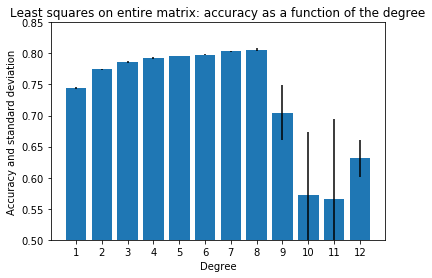

In [33]:
x = range(1,13)
y = [np.median(acc) for acc in mean_std]
yerrs = [np.std(acc) for acc in mean_std]
fig, ax = plt.subplots()
ax.bar(x, y, yerr=yerrs)
ax.set_xticks(x)
ax.set_ybound([0.5, 0.85])
ax.set_title('Least squares on entire matrix: accuracy as a function of the degree')
ax.set_xlabel('Degree')
ax.set_ylabel('Accuracy and standard deviation')
plt.savefig('ls_deg.png')

## Logistic on whole matrix

In [60]:
mean_std = []
x =  range(1, 10)
xtr = preprocessing.preprocess(x_train)
for d in x:
    lr = LogisticRegression(degree=d, gamma=0.1)
    f = lambda ytr, xtr, xte: lr.train(ytr, xtr).predict_labels(xte)
    accs = run.best_cross_validation(y_train_logi, xtr, 5, f)
    mean_std.append(accs)
    print('tested degree', d)
notify()

tested degree 1
tested degree 2
tested degree 3
tested degree 4
tested degree 5
tested degree 6
tested degree 7
tested degree 8
tested degree 9


In [62]:
degree = np.arange(1, 10)
degree = np.reshape(degree, (len(degree), 1))
vals = np.hstack([degree, np.array(mean_std)])
np.savetxt('logistic_entire_degree.csv', vals, delimiter=',', header='d, f1, f2, f3, f4, f5')

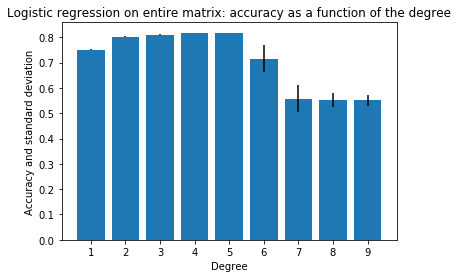

In [63]:
y = [np.median(acc) for acc in mean_std]
yerrs = [np.std(acc) for acc in mean_std]
fig, ax = plt.subplots()
ax.bar(x, y, yerr=yerrs)
ax.set_xticks(x)
#ax.set_ybound([0.5, 0.85])
ax.set_title('Logistic regression on entire matrix: accuracy as a function of the degree')
ax.set_xlabel('Degree')
ax.set_ylabel('Accuracy and standard deviation')
plt.savefig('lr_deg.png')

## Least squares categories

In [133]:
cat = 0
data = []

for cat_data in run.category_iter(y_train, x_train, cat_col=22):
    
    y_train_cat, x_train_cat = cat_data
    xtr = preprocessing.preprocess(x_train_cat)
    
    cat_accs = []
    
    for d in range(1, 13):
        ls = LeastSquares(degree=d, solver='pseudo')
        f = lambda ytr, xtr, xte: ls.train(ytr, xtr).predict_labels(xte)
        accs = run.best_cross_validation(y_train_cat, xtr, 5, f)
        
        cat_accs.append(accs)
        print('tested degree', d, 'on cat', cat)
        
    data.append(cat_accs)
    cat += 1
    
notify()

tested degree 1 on cat 0
tested degree 2 on cat 0
tested degree 3 on cat 0
tested degree 4 on cat 0
tested degree 5 on cat 0
tested degree 6 on cat 0
tested degree 7 on cat 0


KeyboardInterrupt: 

In [ ]:
degree = np.arange(1, 13)
degree = np.reshape(degree, (len(degree), 1))

for idx, cat_accs in enumerate(data):   
    vals = np.hstack([degree, np.array(cat_accs)])
    np.savetxt('leastsquares_cat' + str(idx) + '_degree.csv', vals, delimiter=',', header='d, f1, f2, f3, f4, f5')

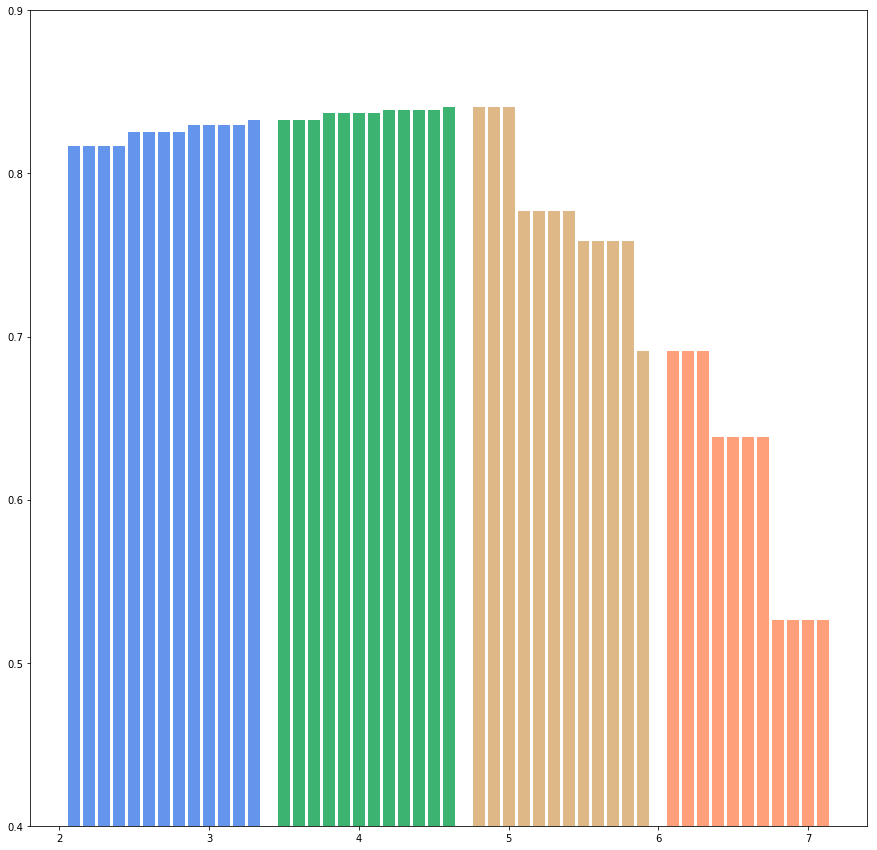

In [130]:
fig, ax = plt.subplots(figsize=(15,15))
x = np.arange(1, 49)
stds = [np.std(accs) for accs in cat for cat in data]
means = [np.mean(accs) for accs in cat for cat in data]

ax.bar(x[:13], means[:13], color='cornflowerblue', width=0.8)
ax.bar(x[13:25]+1, means[13:25], color='mediumseagreen', width=0.8)
ax.bar(x[25:37]+2, means[25:37], color='burlywood', width=0.8)
ax.bar(x[37:49]+3, means[37:49], color='lightsalmon', width=0.8)
ax.set_ybound((0.4, 0.9))
ax.set_xticklabels([i for j in range(4) for i in range(1,13)])


## Logistic categories

In [134]:
cat = 0
data = []

for cat_data in run.category_iter(y_train_logi, x_train, cat_col=22):
    
    y_train_cat, x_train_cat = cat_data
    xtr = preprocessing.preprocess(x_train_cat)
    
    cat_accs = []
    
    for d in range(1, 10):
        lr = LogisticRegression(degree=d, solver='newton', gamma=0.1)
        f = lambda ytr, xtr, xte: lr.train(ytr, xtr).predict_labels(xte)
        accs = run.best_cross_validation(y_train_cat, xtr, 5, f)
        
        cat_accs.append(accs)
        print('tested degree', d, 'on cat', cat)
        
    data.append(cat_accs)
    cat += 1
    
notify()

tested degree 1 on cat 0
tested degree 2 on cat 0
tested degree 3 on cat 0
tested degree 4 on cat 0
tested degree 5 on cat 0
tested degree 6 on cat 0
tested degree 7 on cat 0
tested degree 8 on cat 0
tested degree 9 on cat 0
tested degree 1 on cat 1
tested degree 2 on cat 1
tested degree 3 on cat 1
tested degree 4 on cat 1
tested degree 5 on cat 1
tested degree 6 on cat 1
tested degree 7 on cat 1
tested degree 8 on cat 1
tested degree 9 on cat 1
tested degree 1 on cat 2
tested degree 2 on cat 2
tested degree 3 on cat 2
tested degree 4 on cat 2
tested degree 5 on cat 2
tested degree 6 on cat 2
tested degree 7 on cat 2
tested degree 8 on cat 2
tested degree 9 on cat 2
tested degree 1 on cat 3
tested degree 2 on cat 3
tested degree 3 on cat 3
tested degree 4 on cat 3
tested degree 5 on cat 3
tested degree 6 on cat 3
tested degree 7 on cat 3
tested degree 8 on cat 3
tested degree 9 on cat 3


In [135]:
degree = np.arange(1, 10)
degree = np.reshape(degree, (len(degree), 1))

for idx, cat_accs in enumerate(data):   
    vals = np.hstack([degree, np.array(cat_accs)])
    np.savetxt('logistic_cat' + str(idx) + '_degree.csv', vals, delimiter=',', header='d, f1, f2, f3, f4, f5')

### Basic least squares

In [9]:
basic_least_squares = LeastSquares()

accuracy = cv.cross_validation(y_train, x_train_preprocessed, 5, basic_least_squares)

Step 1 / 5
0.74328
Step 2 / 5
0.742
Step 3 / 5
0.74784
Step 4 / 5
0.74468
Step 5 / 5
0.74414


In [10]:
display_result_basic(accuracy)

Accuracies [0.74328000000000005, 0.74199999999999999, 0.74783999999999995, 0.74468000000000001, 0.74414000000000002]
Mean: 0.744388
Variance: 0.00194901410975


### Least squares degree 8

In [13]:
least_squares_deg_8 = LeastSquares(degree=8)

accuracy = cv.cross_validation(y_train, x_train_preprocessed, 5, least_squares_deg_8)

Step 1 / 5
0.80714
Step 2 / 5
0.8048
Step 3 / 5
0.8121
Step 4 / 5
0.80578
Step 5 / 5
0.80692


In [14]:
display_result_basic(accuracy)

Accuracies [0.80713999999999997, 0.80479999999999996, 0.81210000000000004, 0.80578000000000005, 0.80691999999999997]
Mean: 0.807348
Variance: 0.00252027300109


### Logistic degree 4

In [43]:
logistic_deg_4 = LogisticRegression(degree=4, gamma=0.1)

accuracy = cv.cross_validation(y_train_logi, x_train_preprocessed, 5, logistic_deg_4)

Step 1 / 5
0.81762
Step 2 / 5
0.81664
Step 3 / 5
0.81512
Step 4 / 5
0.81618
Step 5 / 5
0.81604


In [44]:
display_result_basic(accuracy)

Accuracies [0.81762000000000001, 0.81664000000000003, 0.81511999999999996, 0.81618000000000002, 0.81603999999999999]
Mean: 0.81632
Variance: 0.00081613724336


### Least squares cat

In [45]:
least_squares_0 = LeastSquares(degree=7)
least_squares_1 = LeastSquares(degree=12)
least_squares_2 = LeastSquares(degree=11)
least_squares_3 = LeastSquares(degree=11)

models = [least_squares_0, least_squares_1, least_squares_2, least_squares_3]

accuracies, variances = cat_cross_validation(models, y_train, x_train)

Step 1 / 5
0.837503753378
Step 2 / 5
0.835251726554
Step 3 / 5
0.839955960364
Step 4 / 5
0.843809428486
Step 5 / 5
0.847212491242
Step 1 / 5
0.800683518184
Step 2 / 5
0.803585246324
Step 3 / 5
0.806229043075
Step 4 / 5
0.801973175135
Step 5 / 5
0.804681454733
Step 1 / 5
0.830669975186
Step 2 / 5
0.825012406948
Step 3 / 5
0.837419354839
Step 4 / 5
0.836129032258
Step 5 / 5
0.826302729529
Step 1 / 5
0.82536101083
Step 2 / 5
0.835288808664
Step 3 / 5
0.820397111913
Step 4 / 5
0.816110108303
Step 5 / 5
0.830099277978


In [46]:
print_result(accuracies)

Accuracy per cat: [0.84074667200480424, 0.80343048749032753, 0.83110669975186102, 0.8254512635379061]
Variances per cat: [0.0043017082024964801, 0.0019539898856351166, 0.0050096447195751691, 0.0067998692291048801]
Total mean: 0.825183780696


### Logistic cat 

In [47]:
logistic_regression_0 = LogisticRegression(degree=3, gamma=0.1)
logistic_regression_1 = LogisticRegression(degree=6, gamma=0.1)
logistic_regression_2 = LogisticRegression(degree=6, gamma=0.1)
logistic_regression_3 = LogisticRegression(degree=6, gamma=0.1)

models = [logistic_regression_0, logistic_regression_1, logistic_regression_2, logistic_regression_3]

accuracies, variances = cat_cross_validation(models, y_train_logi, x_train)

Step 1 / 5
0.838955059554
Step 2 / 5
0.836002402162
Step 3 / 5
0.838154338905
Step 4 / 5
0.842207987188
Step 5 / 5
0.847112401161
Step 1 / 5
0.801134898117
Step 2 / 5
0.803004900696
Step 3 / 5
0.804359040495
Step 4 / 5
0.803649729172
Step 5 / 5
0.803907660562
Step 1 / 5
0.832853598015
Step 2 / 5
0.828089330025
Step 3 / 5
0.839602977667
Step 4 / 5
0.837717121588
Step 5 / 5
0.827791563275
Step 1 / 5
0.824007220217
Step 2 / 5
0.840703971119
Step 3 / 5
0.827842960289
Step 4 / 5
0.825135379061
Step 5 / 5
0.834837545126


In [48]:
print_result(accuracies)

Accuracy per cat: [0.84048643779401466, 0.8032112458086148, 0.83321091811414405, 0.83050541516245491]
Variances per cat: [0.0038667170300329726, 0.0011268089326181561, 0.0048351224216169426, 0.006339248928082933]
Total mean: 0.82685350422
